<a href="https://colab.research.google.com/github/ShaguftaKhan703/AIML/blob/main/AIML_Module_2_Lab_3_Manifold_Learning_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Lab 3: Manifold Learning Methods
---



Today, we will be focussing on non-linear dimensionality reduction methods or **Manifold learning** methods.

So a manifold is any space that is locally Euclidean. For example, the Earth is round but it looks flat to us. The Earth is a manifold: locally it is flat, but globally we know it is a sphere. Then, manifold learning performs dimensionality reduction by representing data as low-dimensional manifolds embedded in a higher-dimensional space.

We often suspect that high-dim may actually lie on or near a low-dim manifold (often much lower!) and it would be useful if we could reparametrize the data in terms of this manifold, yielding a low-dim embedding BUT - we typically don’t know the form of this manifold.

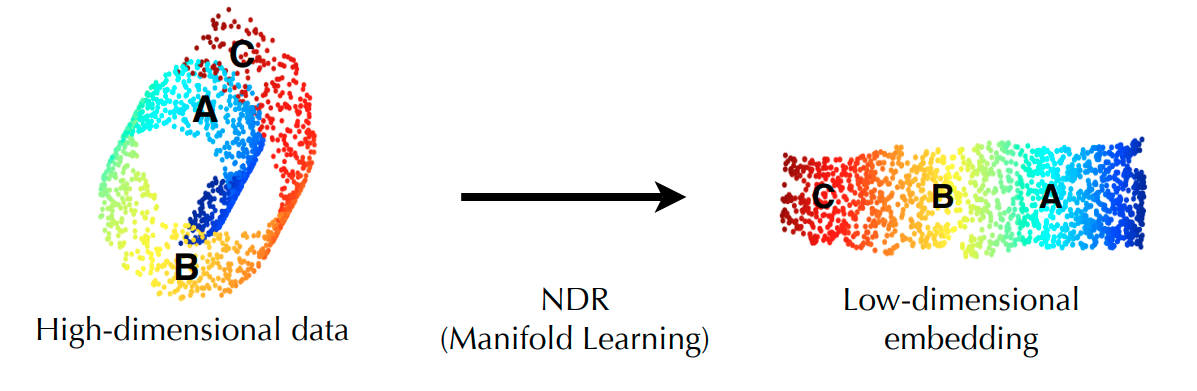

## ISOMAP

---

Isomap stands for **ISOmetric feature MAPping**. Isomap is a non-linear dimensionality reduction method based on the spectral theory which tries to preserve the geodesic distances in the lower dimension.

#### But what are Geodesic Distances?



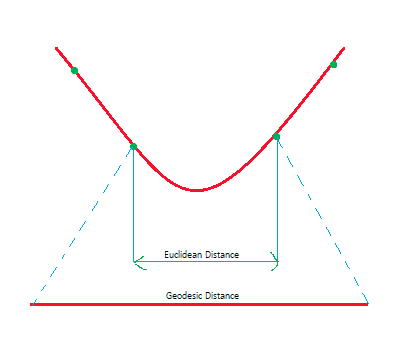

The next question should be:

*How can we compute geodesics without knowing the manifold?* .......
ANSWER: So we build an adjacency graph and approximate geodesic distances by shortest-paths through the graph.


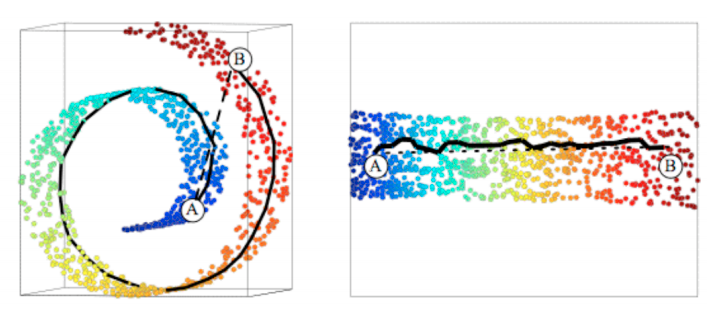

#### 3 steps for ISOMAP:

1. Build the adjacency graph over the points using a Neighbourhood selection method (let's say k nearest neighbours)
2. Compute approximate geodesics: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.
3. Take the top d eigenvectors of the Gram matrix.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

First let us simulate a dataset with the points lying on a manifold which we would want our Isomap to be able to capture.

We will be using the make_s_curve() function in the sklearn.datasets module to make the manifold using 1000 data points

In [13]:
n_points = 3000
X, color = datasets.make_s_curve(n_points, random_state=0)

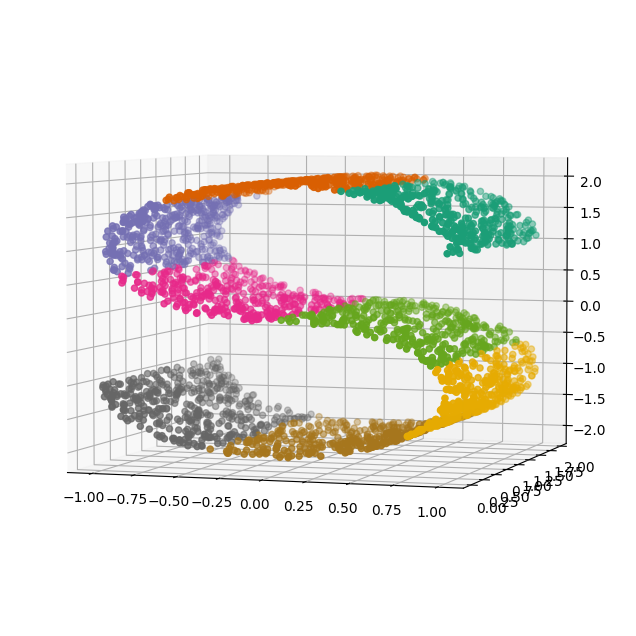

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2)
ax.view_init(4, -72)

Note that all the points appear to be a lying on a curved 2d plane in this 3d dataset. Now we will be coding the Isomap algorithm to perform this manifold learning.


---

### Step 1a: First lets compute the distance matrix (pairwise Euclidean distances) from the data


In [15]:
def dist(a, b):
  '''Computes Euclidean distance between 2 points'''
  return np.sqrt(sum((a - b) ** 2))

distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])

# For N points in the dataset, this matrix should be of the dimension NxN.
# Our dataset had 1000 points, so we expect the dimensions of this matrix to be 1000x1000
print(distances.shape)

(3000, 3000)


### Step 1b: Let us keep only k nearest neighbors for each point in the distance matrix.

In [16]:
# Lets keep only the 10 nearest neighbors, others set to 0 (= unreachable)

n_neighbors = 10
neighbors = np.zeros(distances.shape)

sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
for k,i in enumerate(sort_distances):
    neighbors[k,i] = distances[k,i]

In [17]:
neighbors.shape

(3000, 3000)



---

### Step 2: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.

We will be using the graph_shortest_path() function in the sklearn.utils.graph module.

The function takes an array of positive distances as the parameter. It then performs a shortest-path graph search on the graph and returns a matrix G (shape = N,N), where, G(i,j) gives the shortest distance from point i to point j along the graph.


In [18]:
from scipy.sparse.csgraph import shortest_path

graph = shortest_path(neighbors, directed=False)



---
### Step 3: Take the top d eigenvectors of the Gram matrix.


So let us first compute the gram matrix. If we have a matrix **graph**, then its Gram matrix is **graph**.T * **graph**





In [19]:
gram = (graph ** 2)

We will now be computing the eigenvectors for this matrix, so lets first center the data points.

In [20]:
n_samples = gram.shape[0]

# Mean for each row/column
meanrows = np.sum(gram, axis=0) / n_samples
meancols = (np.sum(gram, axis=1)/n_samples)[:, np.newaxis]

# NUMPY TRICKS: np.newaxis is used to increase the dimension of the existing array by one more dimension. So a (1000,) matrix becomes a (1000,1) matrix.

# Mean across all rows (entire matrix)
meanall = meanrows.sum() / n_samples

gram -= meanrows
gram -= meancols
gram += meanall

Computing eigenvectors

In [21]:
# Using the np.linalg.eig() to compute eigenvectors and eigenvalues for the matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(gram)

# We will be sorting the eigenvalues and to preserve the corresponding eigenvectors, let us make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]

# We want to reduce the dimensionality to **n_components** dimensions, therefore we will be first taking the top **n_components** eigenvectors (sorted in descending by eigenvalues)
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)

# Transforming the matrix (dimensionality reduction)
n_components = 2

reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]
reduced_matrix = reduced_matrix.T



---

## Plotting the resultant reduced_matrix


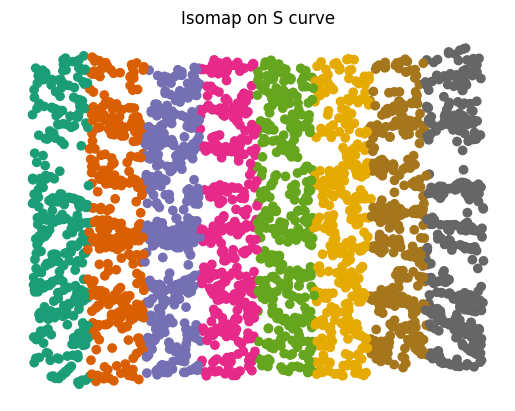

In [22]:
ax = fig.add_subplot(111)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

##### As you can see the Isomap was able to capture the underlying 2d manifold in the S curve dataset.

Now of course there is an easier way to do this, using a predefined library Isomap by sklearn in the manifold module. It just requires you to enter the number of neighbours to be considered and the number of components the graph is to be reduced to.


In [23]:
from sklearn.manifold import Isomap

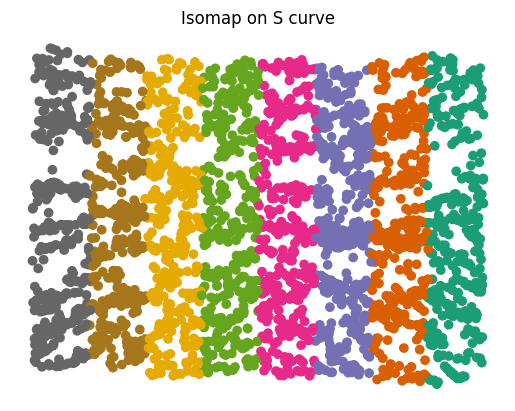

In [24]:
Y = Isomap(n_neighbors=10, n_components=2).fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()



---

### Now let us see if Isomap can learn the manifold representation in some more complex datasets

In [25]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200)
faces.data.shape

(766, 2914)

We loaded 766 images, each having 2914 pixels. Let us visualize our dataset before reducing the dimension

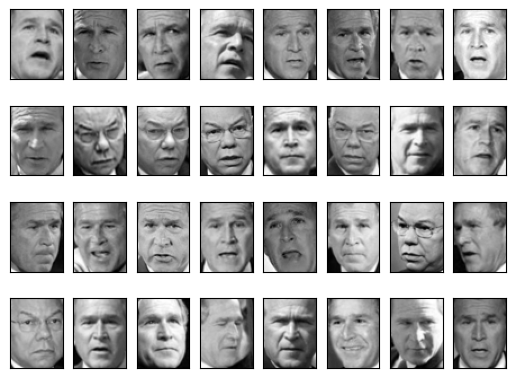

In [26]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Our data is 2914 dimensional and our goal is to learn a low dimensional manifold from it. We first apply PCA (which we learn in Lab 2) and see if PCA is able to reduce it to lower dimensions while preserving much of the variance.

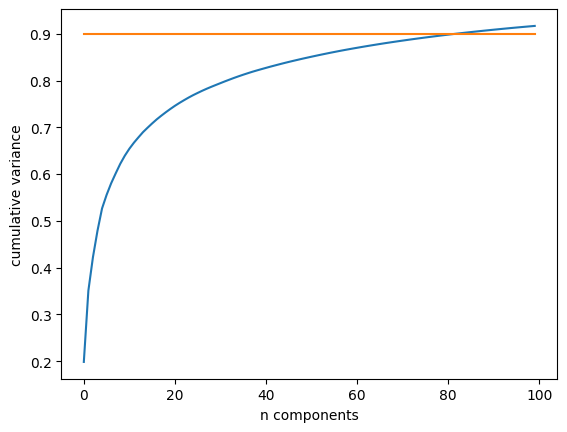

In [27]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 0.9*np.ones(100))

So we can clearly observe that PCA requires more than 70 dimensions to be able to explain 90% of the variance, implying that PCA is failing to learn the underlying manifold effectively.

Let us now try to apply Isomap to this dataset and see if it is able to learn the representation effectively.

In [28]:
model = Isomap(n_components=2, n_neighbors = 5)
proj = model.fit_transform(faces.data)
proj.shape

(766, 2)

We have reduced the dataset from 2914 dimensions to just 2 dimensions. Let us now visualize the result to be able to better understand the latent representation learnt by Isomap

In [29]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Text(0, 0.5, 'Image Darkness')

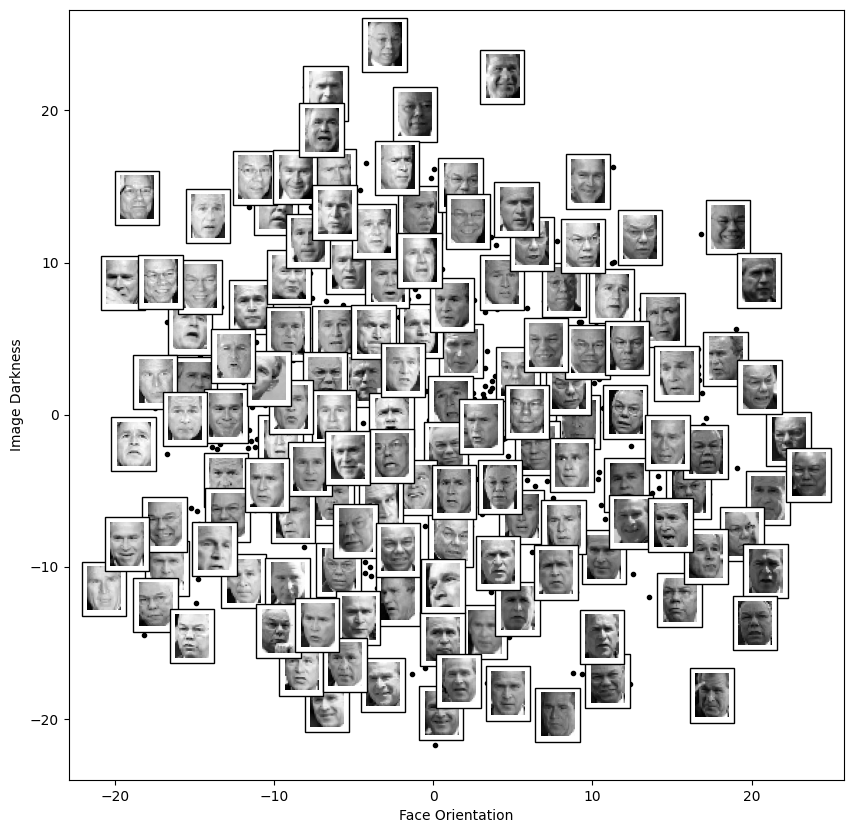

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

We get a very interesting result here. You can see that the Isomap was able to capture very interesting insights regarding the dataset.

If you observe along the x-axis, the images are positioned such that the orientation of the faces changes from left to right. Similarly, the darkness of the image increases in the positive direction of the y-axis.

This clearly indicates that Isomap was able to capture the underlying manifold very precisely in just 2 dimensions.

**You are motivated to play around with the number of neighbors and check if the following holds true across neighbourhoods!**



---


## Some questions you should think about!!

How do you think would the number of neighbors effect the Isomap algorithm? What happens when the number of neighbors considered is very large? What happens when it is very low?


**(When the number of neighbors is large: If you consider a large number of neighbors, Isomap may result in a more global view of the data manifold. The algorithm will capture long-range dependencies and provide a smoother representation of the data.
When the number of neighbors is small: With a small number of neighbors, Isomap focuses on local relationships within the data manifold.)**


When is the ISOMAP algorithm superior to PCA?

**(ISOMAP is superior to PCA when the underlying data has a nonlinear structure. PCA assumes that the data lies on a linear subspace and may not capture the nonlinear relationships in the data. ISOMAP, on the other hand, can learn the nonlinear structure of the data manifold by considering the geodesic distances.)**

---

## Conclusion:
In practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:

1) In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.

2) In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.

3) The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.

4) In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.

5) In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.

6) In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster (though see the megaman package for some more scalable implementations of manifold learning).

Therefore with all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.




---


### Some interesting references:

1) https://axon.cs.byu.edu/Dan/678/miscellaneous/Manifold.example.pdf

2) http://vision.cse.psu.edu/seminars/talks/PRML/David_NDR_lecture.pdf


---

